# Setup

In [2]:
!pip install minari

In [3]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from collections import deque

import minari
import random

from IPython.display import Video

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
!mkdir videos

In [6]:
env = gym.make('BreakoutNoFrameskip-v4', obs_type='rgb', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=True, frame_skip=4, terminal_on_life_loss=True, scale_obs=True)
env = gym.wrappers.RecordVideo(env, video_folder="videos/", name_prefix="breakout_test")
env = gym.wrappers.FrameStackObservation(env, 4)  # stack 4 consecutive frames

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


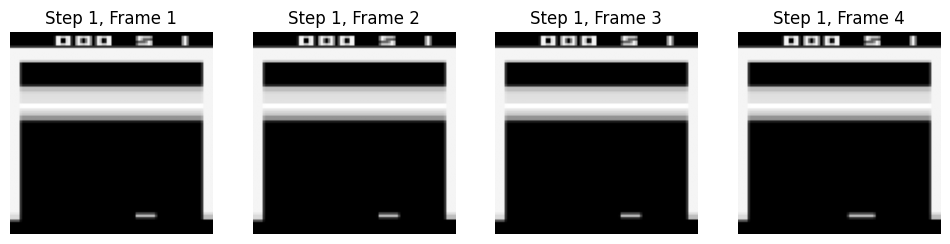

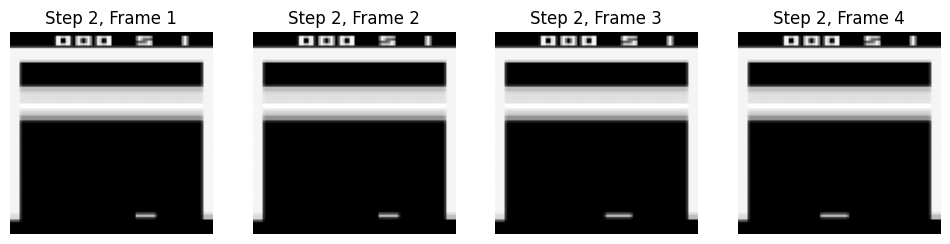

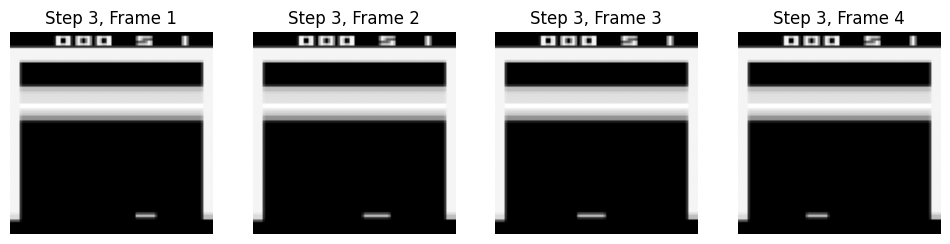

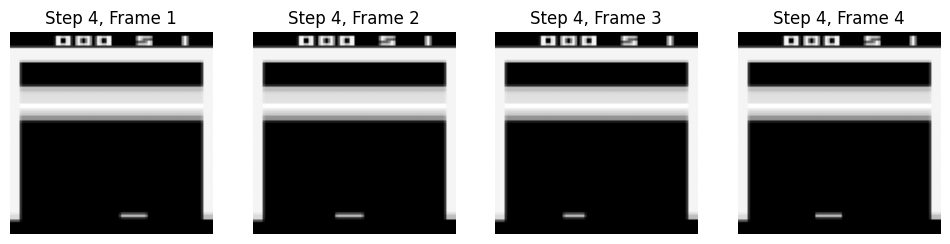

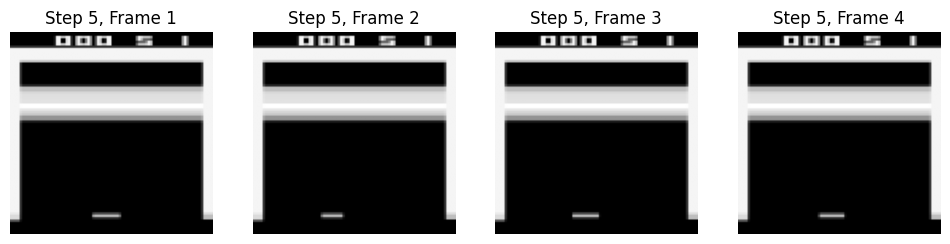

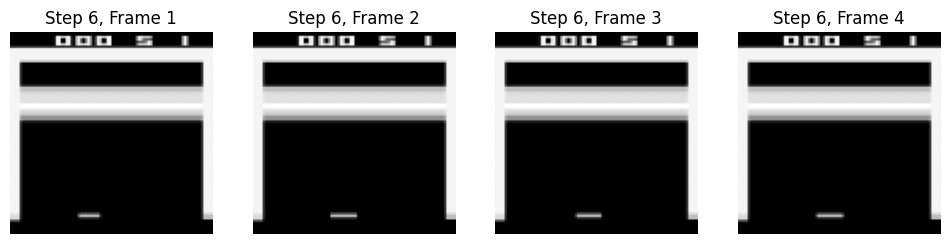

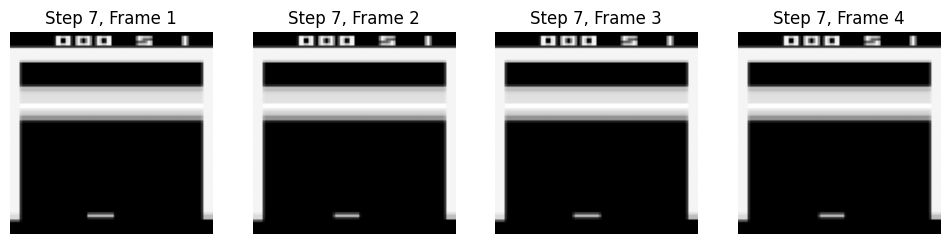

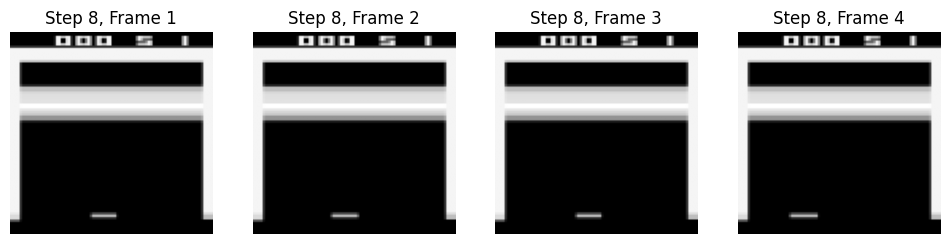

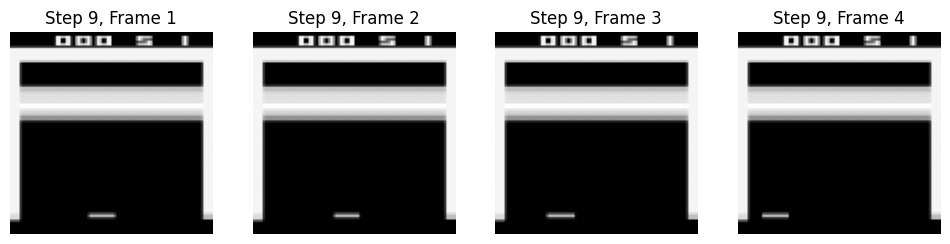

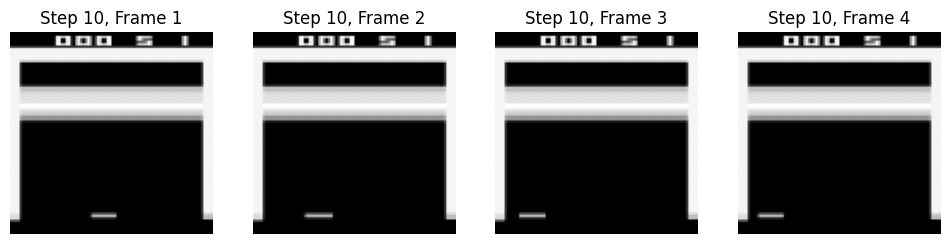

In [7]:
obs, info = env.reset()
frames = [obs]

total_reward = 0
for step in range(10):
    action = env.action_space.sample()  # random action
    obs, reward, done, truncated, info = env.step(action)

    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    for i in range(4):
        axes[i].imshow(obs[i, :, :], cmap='gray')
        axes[i].set_title(f'Step {step+1}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    frames.append(obs)
    total_reward += reward
    if done or truncated:
        break

env.close()


In [8]:
Video("videos/breakout_test-episode-0.mp4", embed=True)

#SL

In [ ]:
class MinariDataset(Dataset):
    def __init__(self, dataset, stack_size=4):
        # obs
        obs = np.concatenate([ep.observations for ep in dataset], axis=0)
        obs = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in obs], dtype=np.float32)
        obs = np.array([cv2.resize(frame, (84, 84)) for frame in obs], dtype=np.float32)
        obs = obs / 255.0
        obs = (obs > 0.1).astype(np.float32)
        obs = (obs - 0.5) * 2

        obs = obs[:,8:,:]
        obs = obs[:,:,4:80]

        obs[:,:8,:] = 0.5

        self.obs = obs

        # diffs
        diffs = (obs[1:] - obs[:-1])/2
        self.diffs = diffs

        # ball position

        h,w = obs.shape[1:]
        ds = diffs.copy()
        ds[:, 67:70, :] = 0.0
        ball_pos = np.zeros((obs.shape[0], 2), dtype=np.float32)

        for i in range(obs.shape[0]):
            cond = (ds[max(0,i-1),:,:] == 1) | (ds[min(obs.shape[0]-2,i),:,:] == -1)
            idx = np.argwhere(cond)
            if len(idx) > 0:
                ball_pos[i, 0] = idx[:, 0].mean() / h
                ball_pos[i, 1] = idx[:, 1].mean() / w

        ball_pos = (ball_pos - 0.5)*2
        self.ball_pos = ball_pos

        self.stack_size = stack_size
        self.max_idx = len(self.obs) - stack_size

    def __len__(self):
        return self.max_idx

    def __getitem__(self, idx):

          # --- Target ---
          stack = self.obs[idx : idx + self.stack_size].copy()  # (stack_size, H, W)
          target = torch.tensor(stack, dtype=torch.float32)

          # --- Input ---
          drop_idx = random.randint(0, self.stack_size - 1)
          masked_stack = stack.copy()
          masked_stack[drop_idx] = 0.0
          x = torch.tensor(masked_stack, dtype=torch.float32)

          # --- Diff ---
          # differences between consecutive frames: (stack_size-1, H, W)
          diff_stack = self.diffs[idx : idx + self.stack_size - 1].copy()
          diff_stack = torch.tensor(diff_stack, dtype=torch.float32)

          # --- Compute ball position ---
          # ball position: (2, 4)
          ball_pos = self.ball_pos[idx : idx + self.stack_size].copy()
          ball_pos = torch.tensor(ball_pos, dtype=torch.float32)


          return x, target, diff_stack, ball_pos

In [32]:
minari_dataset = minari.load_dataset('atari/breakout/expert-v0', download=True)
minari_dataset = MinariDataset(dataset = minari_dataset)
minari_dataloader = DataLoader(minari_dataset, batch_size=512, shuffle=True)

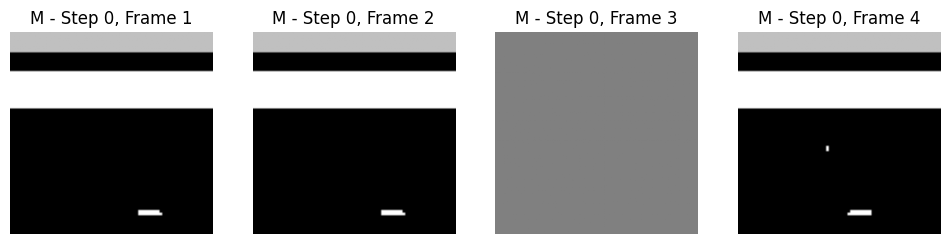

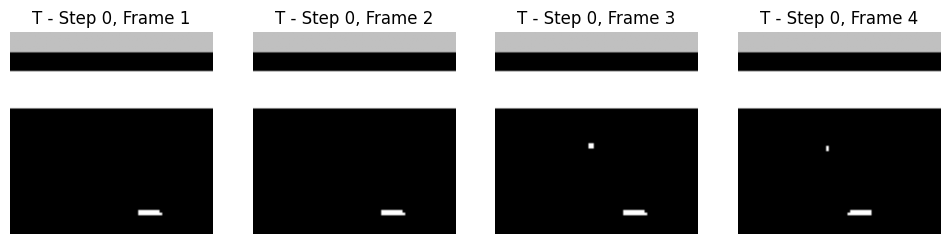

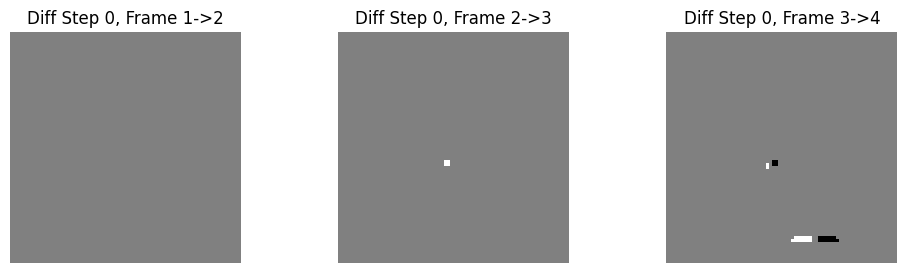

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.5592, 0.4671],
        [0.5724, 0.4342]])


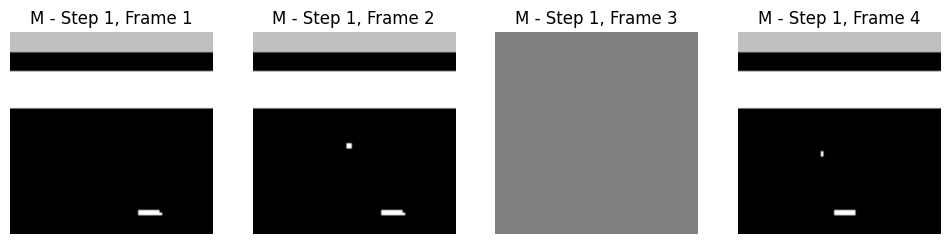

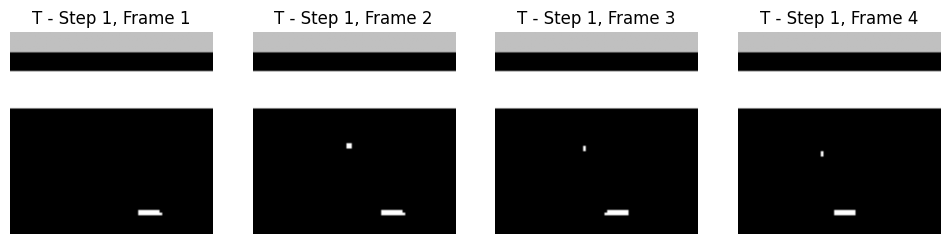

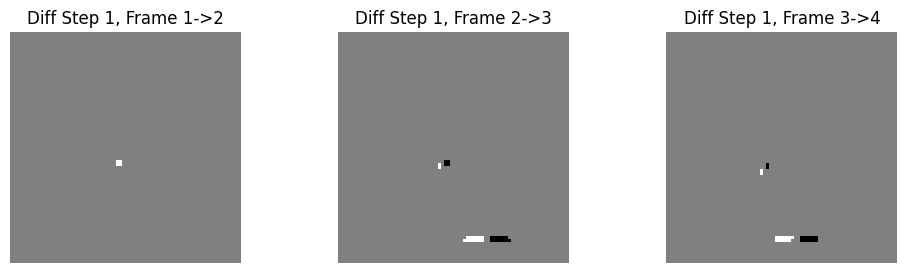

tensor([[0.0000, 0.0000],
        [0.5592, 0.4671],
        [0.5724, 0.4342],
        [0.5987, 0.4079]])


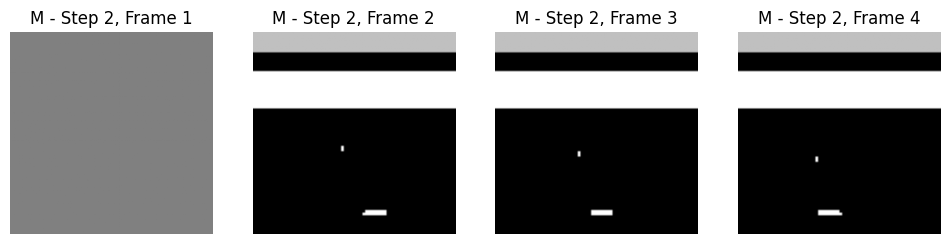

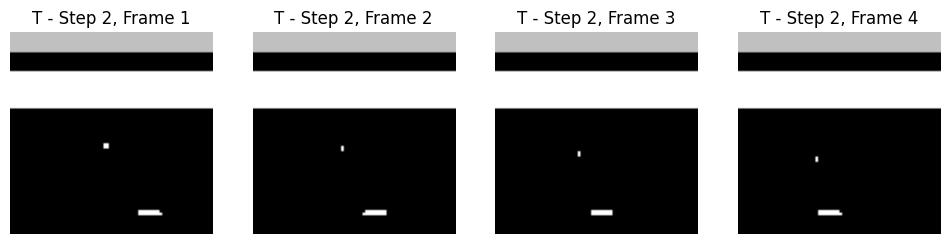

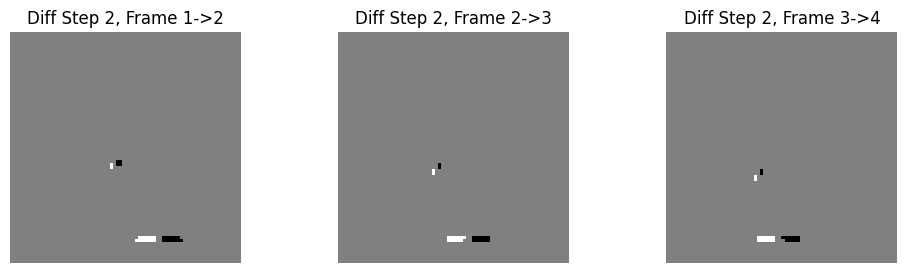

tensor([[0.5592, 0.4671],
        [0.5724, 0.4342],
        [0.5987, 0.4079],
        [0.6250, 0.3816]])


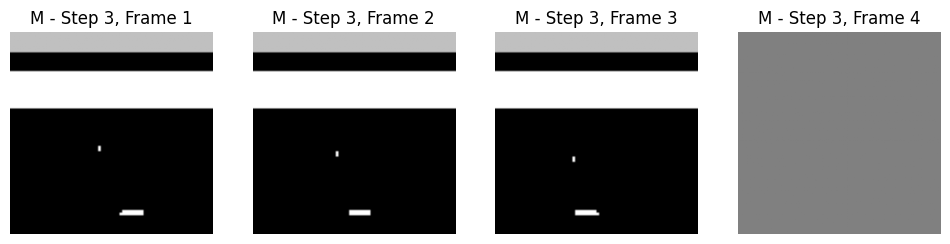

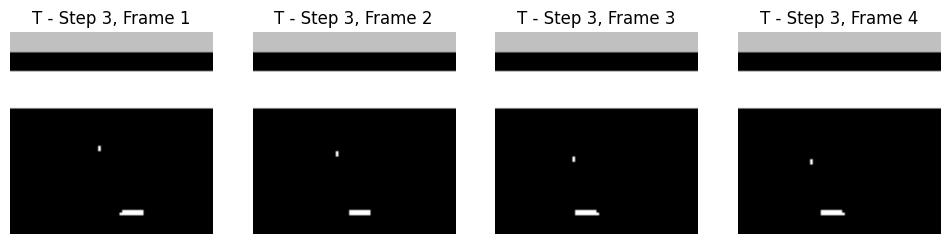

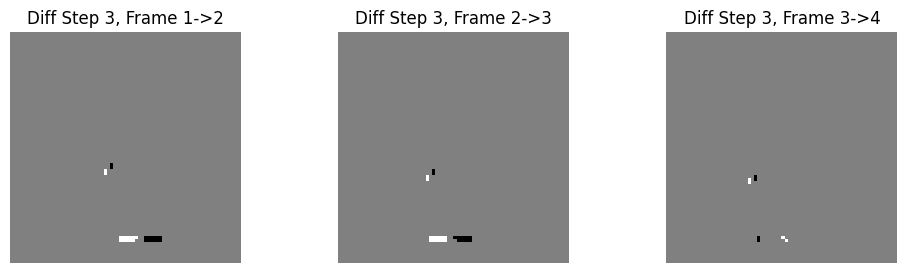

tensor([[0.5724, 0.4342],
        [0.5987, 0.4079],
        [0.6250, 0.3816],
        [0.6382, 0.3553]])


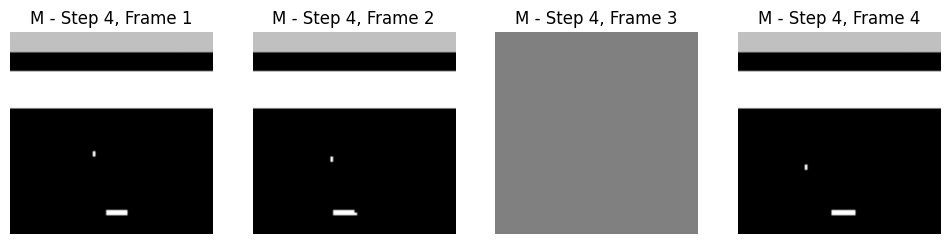

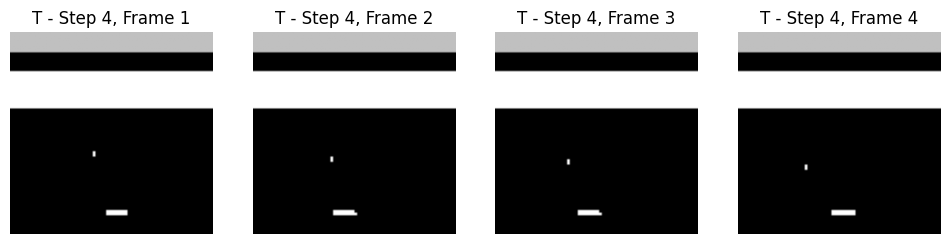

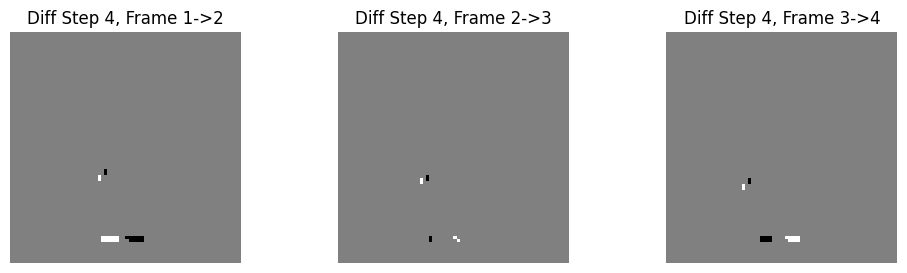

tensor([[0.5987, 0.4079],
        [0.6250, 0.3816],
        [0.6382, 0.3553],
        [0.6645, 0.3289]])


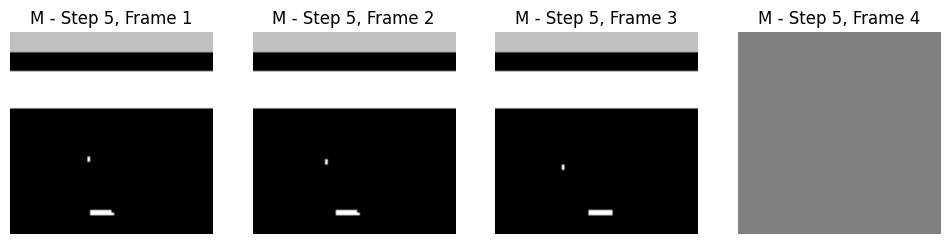

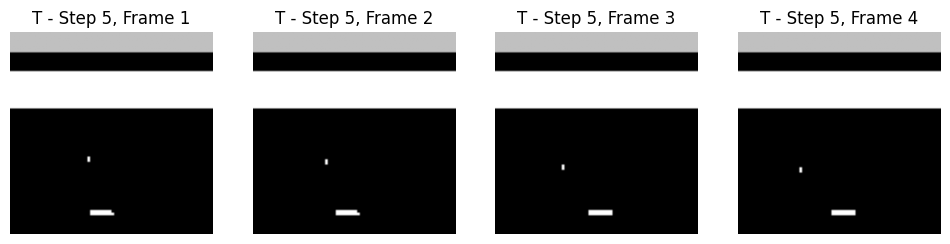

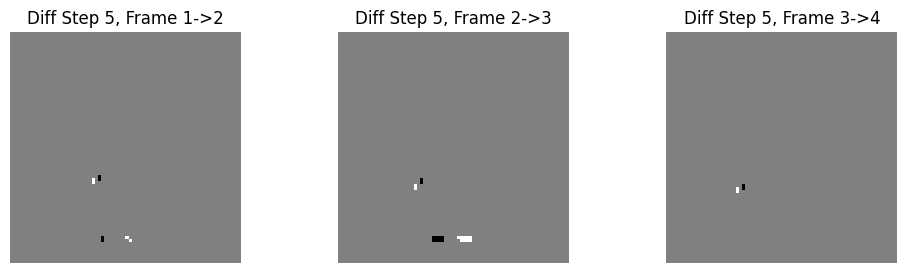

tensor([[0.6250, 0.3816],
        [0.6382, 0.3553],
        [0.6645, 0.3289],
        [0.6776, 0.3026]])


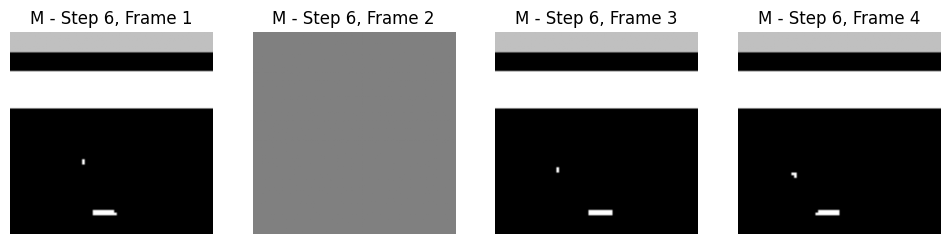

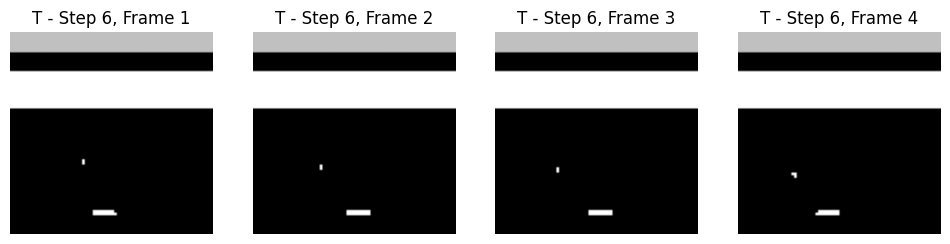

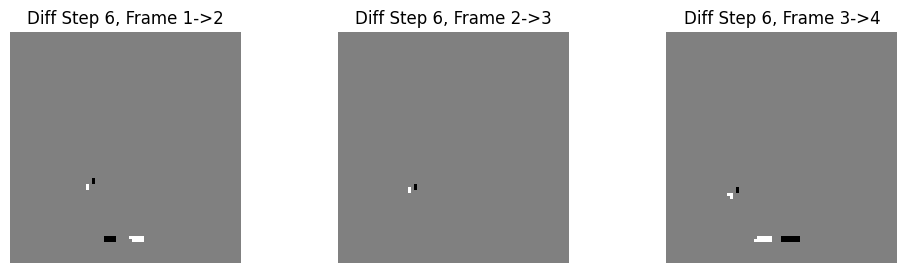

tensor([[0.6382, 0.3553],
        [0.6645, 0.3289],
        [0.6776, 0.3026],
        [0.7018, 0.2719]])


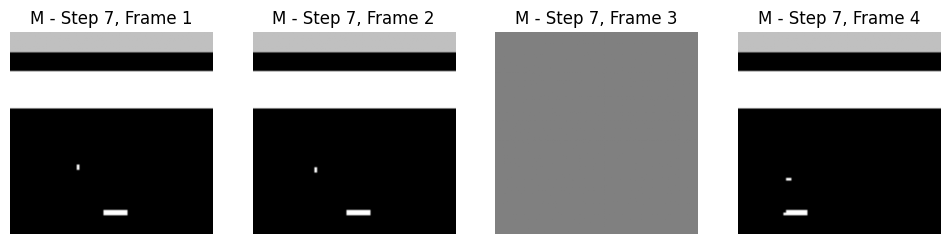

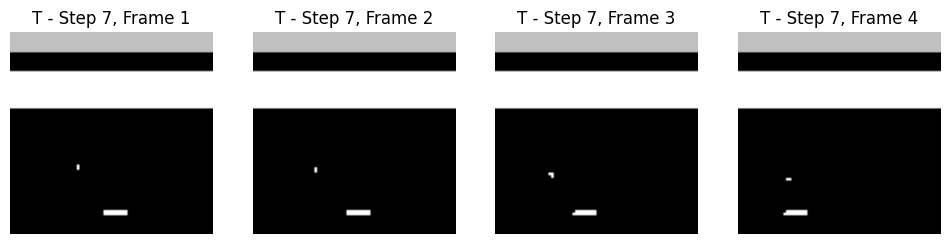

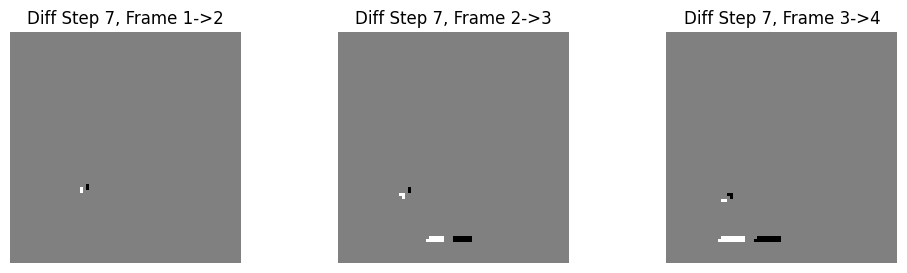

tensor([[0.6645, 0.3289],
        [0.6776, 0.3026],
        [0.7018, 0.2719],
        [0.7237, 0.2434]])


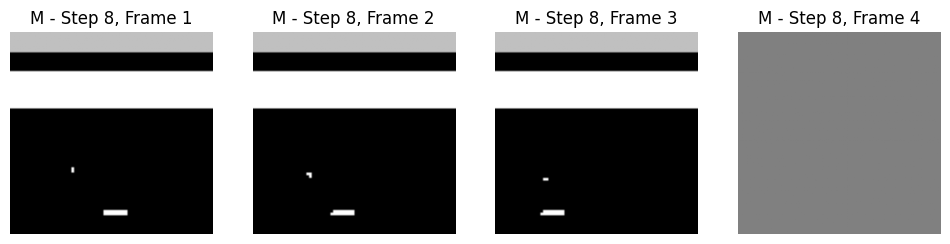

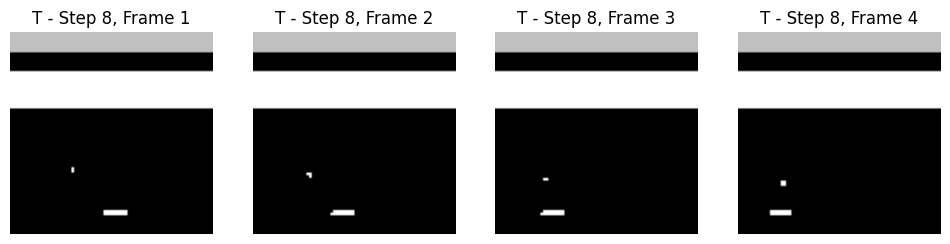

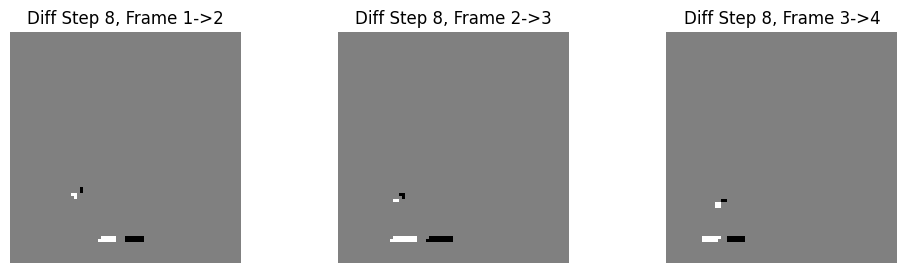

tensor([[0.6776, 0.3026],
        [0.7018, 0.2719],
        [0.7237, 0.2434],
        [0.7434, 0.2171]])


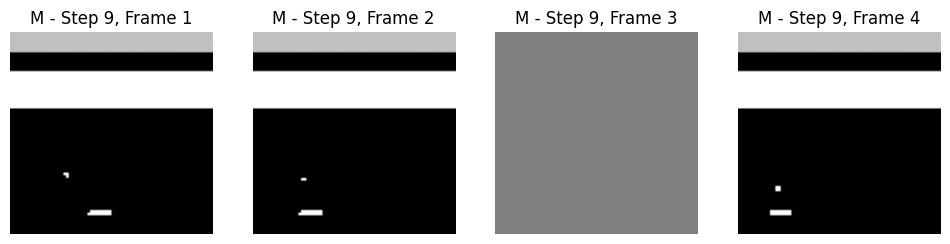

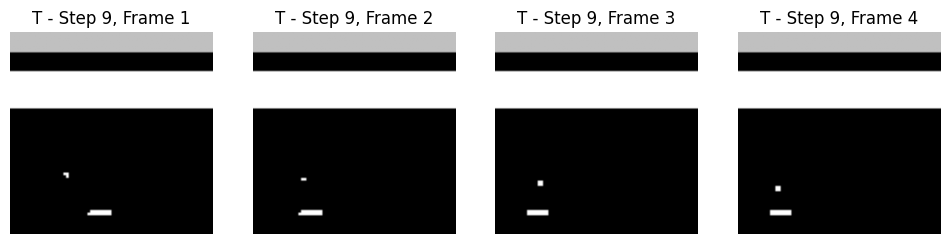

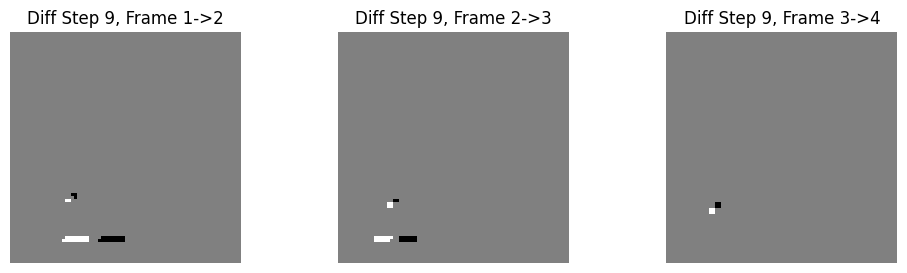

tensor([[0.7018, 0.2719],
        [0.7237, 0.2434],
        [0.7434, 0.2171],
        [0.7697, 0.1908]])


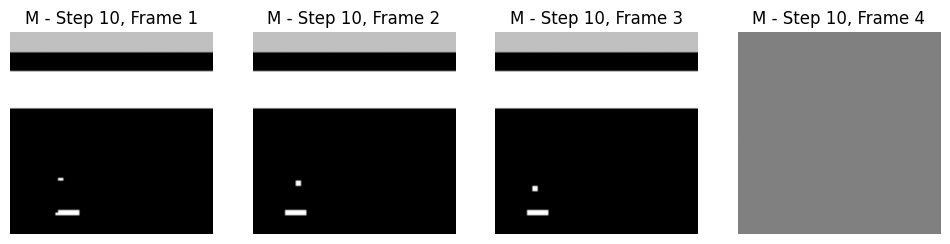

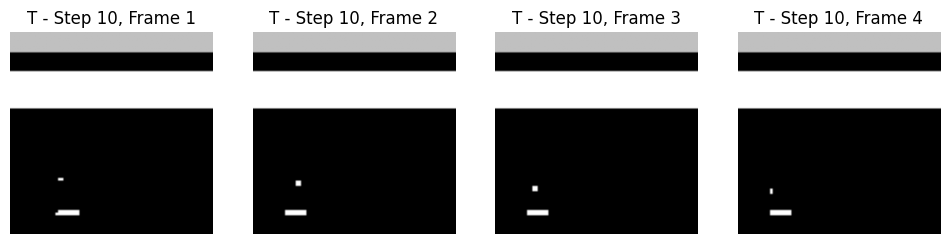

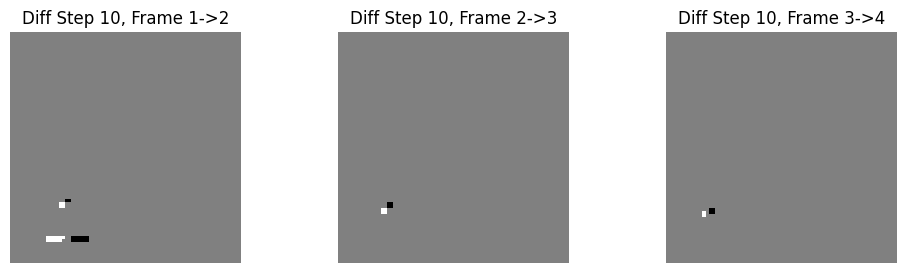

tensor([[0.7237, 0.2434],
        [0.7434, 0.2171],
        [0.7697, 0.1908],
        [0.7829, 0.1579]])


In [33]:
for j, (x, target, diff_stack, ball_pos) in enumerate(minari_dataset):
    # --- Masked input ---
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        axes[i].imshow(x[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'M - Step {j}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    # --- Target stack ---
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        axes[i].imshow(target[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'T - Step {j}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    # --- Difference frames (optional) ---
    fig, axes = plt.subplots(1, diff_stack.shape[0], figsize=(12, 3))
    for i in range(diff_stack.shape[0]):
        axes[i].imshow(diff_stack[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'Diff Step {j}, Frame {i+1}->{i+2}')
        axes[i].axis('off')
    plt.show()

    # --- Ball pos ---
    print(ball_pos)



    if j >= 10:
        break


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels=4, latent_dim=128):
        super().__init__()
        # --- Encoder ---
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)  # -> (32, 18, 18)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)             # -> (64, 8, 8)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)             # -> (64, 6, 6)
        self.fc1 = nn.Linear(6*6*64, latent_dim)

        # --- Decoder ---
        self.fc2 = nn.Linear(latent_dim, 6*6*64)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)  # -> (64, 8, 8)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)  # -> (32, 18, 18)
        self.deconv3 = nn.ConvTranspose2d(32, input_channels, kernel_size=8, stride=4)  # -> (4, 84, 84)

        # --- Difference Decoder ---
        # Predicts (stack_size-1) difference frames per input stack
        self.diff_fc2 = nn.Linear(latent_dim, 64*6*6)
        self.diff_deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)
        self.diff_deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        self.diff_deconv3 = nn.ConvTranspose2d(32, input_channels-1, kernel_size=8, stride=4)

        # --- Ball Position Decoder (2×4) ---
        self.ball_fc = nn.Linear(latent_dim, 8)  # → 8 numbers: 2 rows × 4 columns


    def forward(self, x):

        # --- Encoder ---
        x_enc = F.leaky_relu(self.conv1(x))
        x_enc = F.leaky_relu(self.conv2(x_enc))
        x_enc = F.leaky_relu(self.conv3(x_enc))
        x_enc_flat = x_enc.view(x_enc.size(0), -1)
        latent = F.leaky_relu(self.fc1(x_enc_flat))

        # --- Full-frame Decoder ---
        x_dec = F.leaky_relu(self.fc2(latent))
        x_dec = x_dec.view(x_dec.size(0), 64, 6, 6)
        x_dec = F.leaky_relu(self.deconv1(x_dec))
        x_dec = F.leaky_relu(self.deconv2(x_dec))
        recon_full = torch.tanh(self.deconv3(x_dec))  # (B, 4, H, W)

        # --- Difference Decoder ---
        d_dec = F.leaky_relu(self.diff_fc2(latent))
        d_dec = d_dec.view(d_dec.size(0), 64, 6, 6)
        d_dec = F.leaky_relu(self.diff_deconv1(d_dec))
        d_dec = F.leaky_relu(self.diff_deconv2(d_dec))
        recon_diff = torch.tanh(self.diff_deconv3(d_dec))  # (B, 3, H, W)  (stack_size-1)

        # --- Ball Position Head ---
        ball_raw = torch.tanh(self.ball_fc(latent))        # (B, 8)
        ball_pos = ball_raw.view(-1, 4, 2)           # (B, 2, 4)


        return recon_full, recon_diff, ball_pos, latent

In [36]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

In [37]:
state_dict = torch.load("autoencoder_6.pth", map_location=device)
autoencoder.load_state_dict(state_dict, strict=False,)

_IncompatibleKeys(missing_keys=['ball_fc.weight', 'ball_fc.bias'], unexpected_keys=[])

In [38]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 000 | Loss: 0.386458


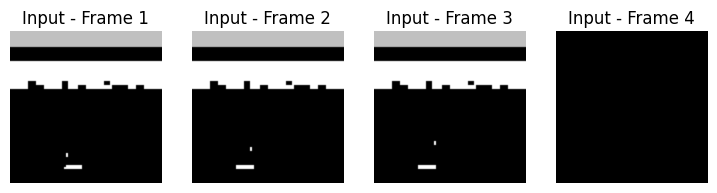

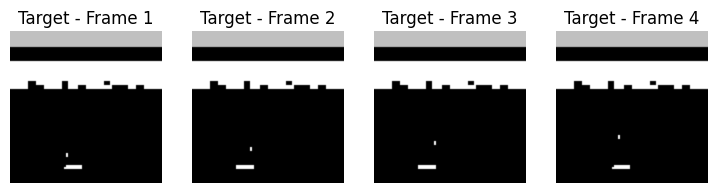

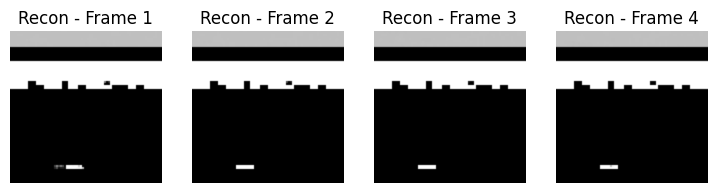

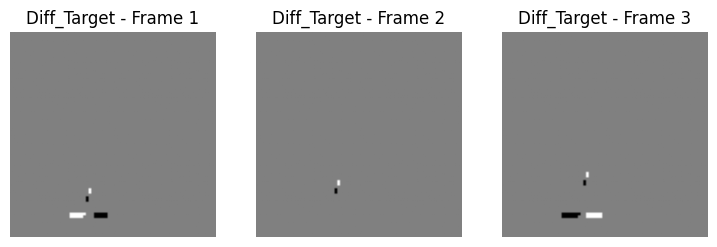

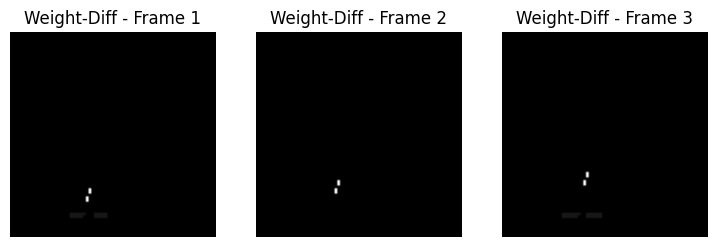

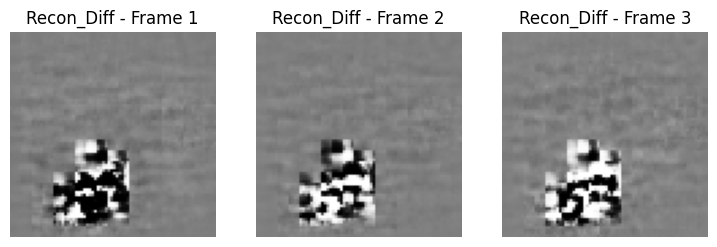

Pos Target: tensor([[0.8092, 0.3684],
        [0.7697, 0.3816],
        [0.7303, 0.3947],
        [0.6908, 0.4079]], device='cuda:0')
Recon Pos: tensor([[1.5091e-23, 1.0000e+00],
        [1.0000e+00, 9.4886e-17],
        [0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00]], device='cuda:0', grad_fn=<SelectBackward0>)


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 001 | Loss: 0.366849


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 002 | Loss: 0.353188


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 003 | Loss: 0.340462


  0%|          | 0/46 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
num_epochs = 1001

for epoch in tqdm(range(num_epochs)):

    autoencoder.train()
    total_loss = 0.0

    for input, target, diff_target, pos_target  in tqdm(minari_dataloader,leave=False):

        input, target, diff_target, pos_target = input.to(device), target.to(device), diff_target.to(device), pos_target.to(device)

        # --- Forward pass ---
        recon, recon_diff, recon_pos, _ = autoencoder(input)

        # --- Loss computation ---
        # Full-stack reconstruction
        loss = F.mse_loss(recon, target)

        # Difference prediction with weighted loss

        weight_diff = (diff_target != 0).float()

        ball_mask = torch.zeros_like(weight_diff)
        ball_mask[:, :, 29:67, :] = 1.0
        ball_mask[:, :, 9:15, :] = 1.0

        weight_diff = weight_diff + 10 * weight_diff * ball_mask
        weight_diff = weight_diff + 0.01

        weight_diff = weight_diff / weight_diff.sum()


        loss_diff = ((recon_diff - diff_target)**2 * weight_diff).sum()

        # Ball position prediction
        loss_pos = F.mse_loss(recon_pos, pos_target)

        # Total loss
        loss = loss + loss_diff + loss_pos

        # --- Backprop ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input.size(0)

    avg_loss = total_loss / len(minari_dataloader.dataset)
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

    # --- Visualization / checkpointing ---
    if epoch % 50 == 0 or (epoch in [5, 10]):

        torch.save(autoencoder.state_dict(), f"autoencoder_{epoch:03d}.pth")

        shards = {"Input": input,
          "Target": target,
          "Recon": recon,
          "Diff_Target": diff_target,
          "Weight-Diff": weight_diff,
          "Recon_Diff": recon_diff
        }

        for key, value in shards.items():

          shard = value[0].cpu().detach().numpy()

          fig, axes = plt.subplots(1, shard.shape[0], figsize=(9, 3))
          for i in range(shard.shape[0]):
              axes[i].imshow(shard[i], cmap='gray')
              axes[i].set_title(f'{key} - Frame {i+1}')
              axes[i].axis('off')
          plt.show()

        print(f"Pos Target: {pos_target[0]}")
        print(f"Recon Pos: {recon_pos[0]}")



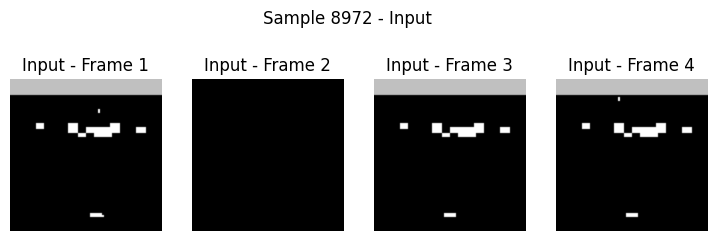

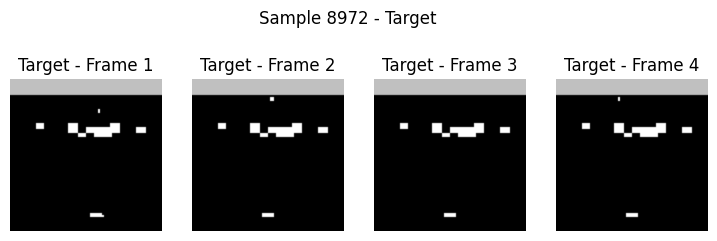

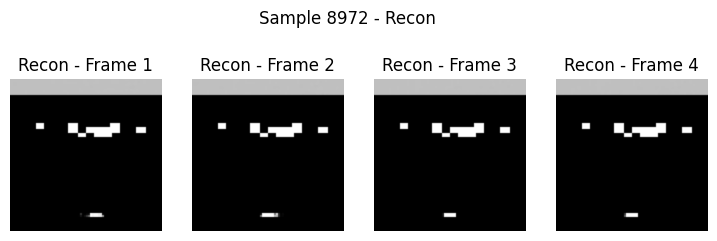

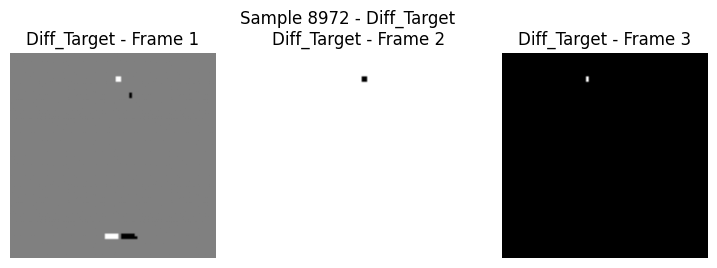

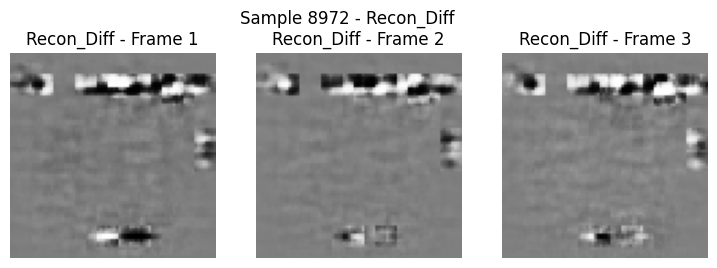

Ball Pos Target: tensor([[0.2039, 0.5789],
        [0.1250, 0.5197],
        [0.0000, 0.0000],
        [0.1250, 0.4079]])
Ball Pos Recon: tensor([[[1.5162e-03, 3.4064e-29],
         [3.1709e-34, 9.9421e-01],
         [4.4312e-33, 0.0000e+00],
         [6.0964e-23, 5.3611e-32]]], device='cuda:0')


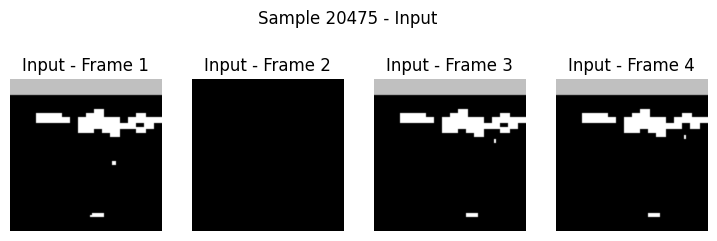

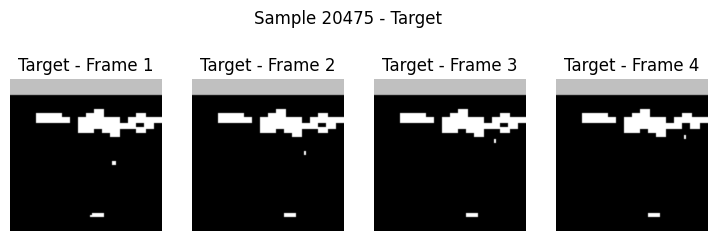

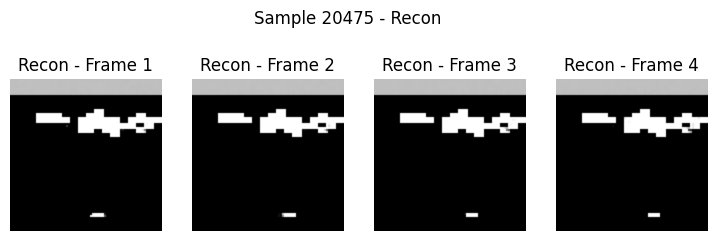

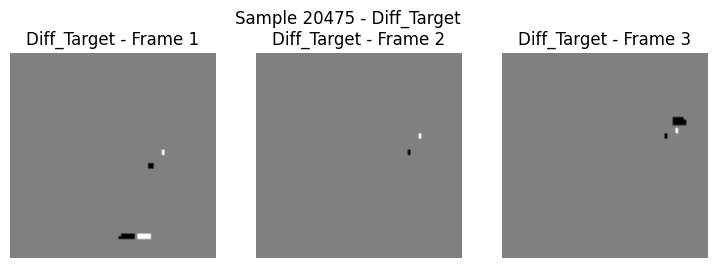

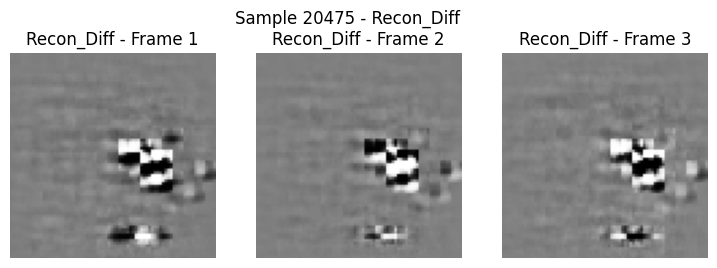

Ball Pos Target: tensor([[0.5461, 0.6776],
        [0.4803, 0.7368],
        [0.3388, 0.8454],
        [0.3750, 0.8421]])
Ball Pos Recon: tensor([[[0.0000e+00, 0.0000e+00],
         [4.5563e-15, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00]]], device='cuda:0')


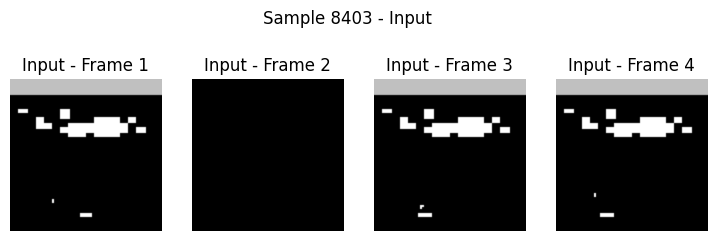

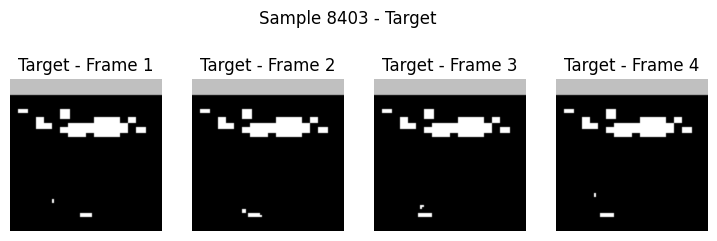

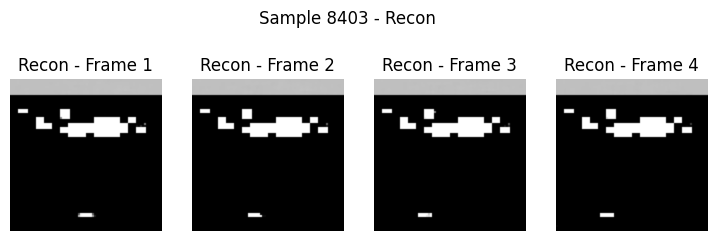

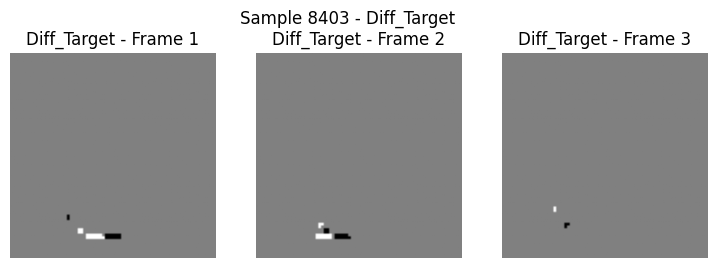

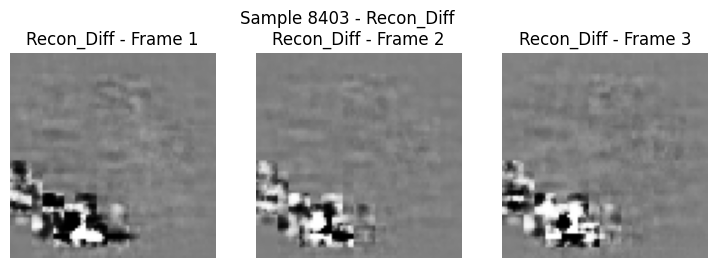

Ball Pos Target: tensor([[0.7961, 0.2763],
        [0.8618, 0.3355],
        [0.8333, 0.3070],
        [0.7566, 0.2500]])
Ball Pos Recon: tensor([[[7.9912e-22, 0.0000e+00],
         [3.6271e-20, 1.0000e+00],
         [1.0000e+00, 2.4603e-29],
         [2.4192e-27, 0.0000e+00]]], device='cuda:0')


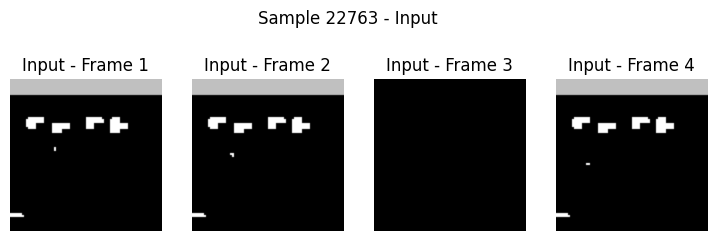

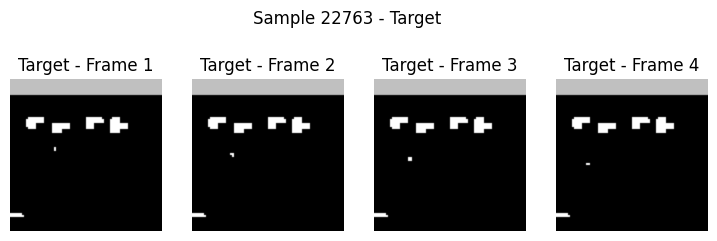

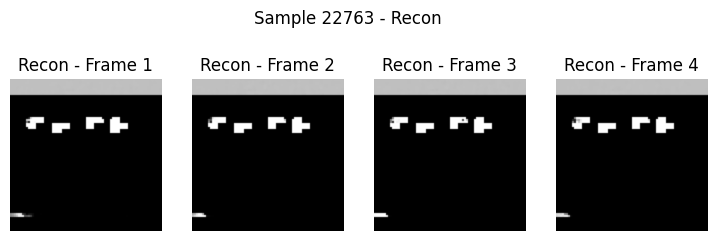

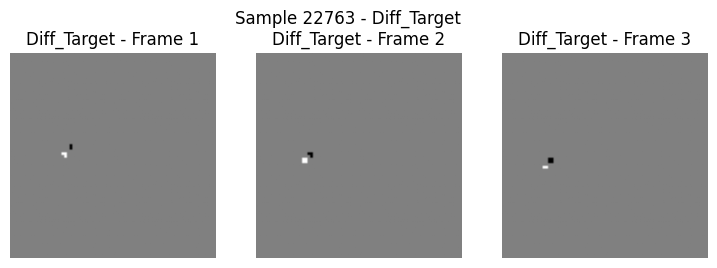

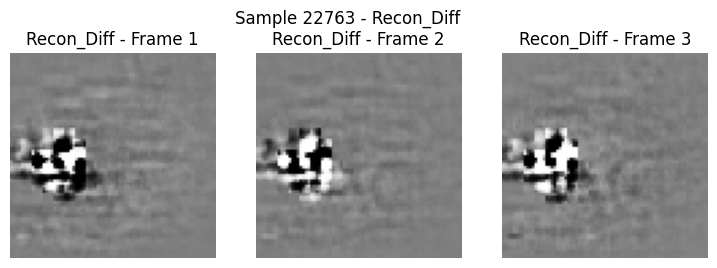

Ball Pos Target: tensor([[0.4539, 0.2895],
        [0.4912, 0.2588],
        [0.5197, 0.2303],
        [0.5526, 0.2039]])
Ball Pos Recon: tensor([[[0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 1.]]], device='cuda:0')


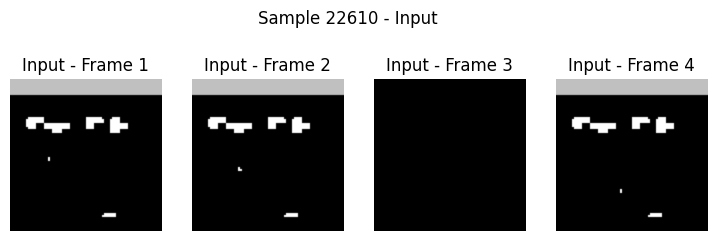

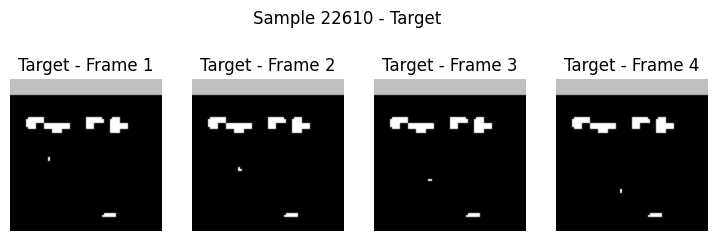

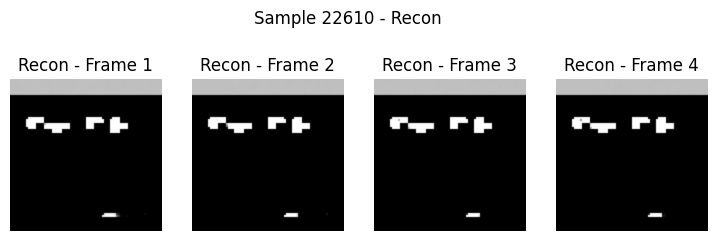

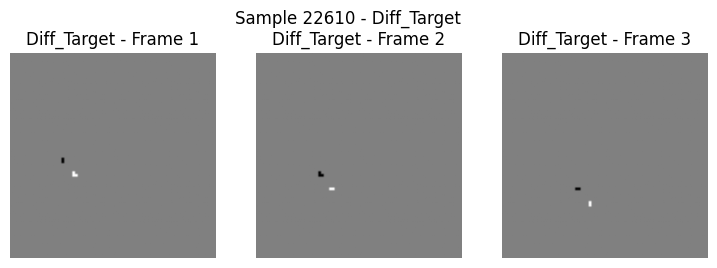

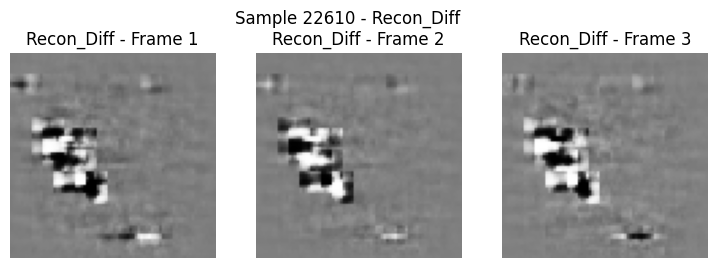

Ball Pos Target: tensor([[0.5197, 0.2500],
        [0.5877, 0.3070],
        [0.6579, 0.3618],
        [0.7303, 0.4211]])
Ball Pos Recon: tensor([[[0.0000e+00, 0.0000e+00],
         [4.6875e-08, 0.0000e+00],
         [1.9344e-33, 5.2938e-33],
         [0.0000e+00, 1.0000e+00]]], device='cuda:0')


In [ ]:
autoencoder.eval()
num_samples = 5  # number of samples to visualize
sample_indices = random.sample(range(len(minari_dataset)), num_samples)

for idx in sample_indices:
    input, target, diff_target, pos_target = minari_dataset[idx]

    # Add batch dimension and move to device
    input = input.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        recon, recon_diff,recon_pos, _ = autoencoder(input)

    # Move tensors back to CPU for plotting
    input_np = input[0].cpu().numpy()
    target_np = target.cpu().numpy()
    recon_np = recon[0].cpu().numpy()
    diff_target_np = diff_target.cpu().numpy()
    recon_diff_np = recon_diff[0].cpu().numpy()

    # --- Plot ---
    shards = {
        "Input": input_np,
        "Target": target_np,
        "Recon": recon_np,
        "Diff_Target": diff_target_np,
        "Recon_Diff": recon_diff_np
    }

    for key, value in shards.items():
        fig, axes = plt.subplots(1, value.shape[0], figsize=(9, 3))
        for i in range(value.shape[0]):
            axes[i].imshow(value[i], cmap='gray')
            axes[i].set_title(f'{key} - Frame {i+1}')
            axes[i].axis('off')
        plt.suptitle(f'Sample {idx} - {key}')
        plt.show()


    print(f"Pos Target: {pos_target}")
    print(f"Pos Recon: {recon_pos}")

# RL

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_channels=4, num_actions=4):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
q = DQN()
q_hat = DQN()
q_hat.load_state_dict(q.state_dict())

optimizer_q = torch.optim.Adam(q.parameters(), lr=0.001)

q = q.to(device)
q_hat = q_hat.to(device)

In [ ]:

n_steps = 5e7
eps = 0.1
gamma = 0.99

training_steps_per_episode = 3

transitions = []

for episode_idx in tqdm(range(int(5e5))):

  transitions = []

  if n_steps < 0:
    break

  obs, info = env.reset()

  for step in tqdm(range(1, 1001)):

    if np.random.rand() < eps:
      action = env.action_space.sample()

    else:
      with torch.no_grad():
        q_values = q(torch.from_numpy(obs).unsqueeze(0).to(device))
        action = torch.argmax(q_values).item()

    obs_, reward, done, truncated, info = env.step(action)

    transitions.append((obs, action, reward, obs_, done, truncated))

    obs = obs_

    if done or truncated:
      n_steps -= step
      break


    for training_step_ids in range(training_steps_per_episode):

      transition = random.sample(transitions, 1)

      obs, action, reward, obs_, done, truncated = transition[0]

      q_values = q_hat(torch.from_numpy(obs_).unsqueeze(0).to(device))

      if done or truncated:
        y = reward
      else:
        y = reward + gamma * torch.max(q_values)

      loss = (y - q(torch.from_numpy(obs).unsqueeze(0).to(device))[0][action])**2
      optimizer_q.zero_grad()
      loss.backward()
      optimizer_q.step()

    if step % 100 == 0:
      q_hat.load_state_dict(q.state_dict())


In [ ]:
!mkdir videos/